In [1]:
%matplotlib inline

import cv2
import os
import numpy as np 
import pandas as pd
from glob import glob

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from skimage.io import imread

from keras.models import load_model
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf


/home/faisal/anaconda3/envs/ai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
DATA_DIR = os.path.join('.', 'data')
TRAIN_IMAGE_DIR = os.path.join(DATA_DIR, 'Train/CameraRGB')
TRAIN_LABEL_DIR = os.path.join(DATA_DIR, 'Train/CameraSeg')

clara_seg_data = pd.DataFrame(dict(image = glob(os.path.join(TRAIN_IMAGE_DIR, '*.*p*g'))))
clara_seg_data['id'] = clara_seg_data['image'].map(lambda x: x.split('/')[-1].split('.')[0])
clara_seg_data['label'] = clara_seg_data['image'].map(lambda x: os.path.join(TRAIN_LABEL_DIR, x.split('/')[-1]))
clara_seg_data.sample(5)

,image,id,label
137,./data/Train/CameraRGB/325.png,325,./data/Train/CameraSeg/325.png
582,./data/Train/CameraRGB/5.png,5,./data/Train/CameraSeg/5.png
233,./data/Train/CameraRGB/826.png,826,./data/Train/CameraSeg/826.png
84,./data/Train/CameraRGB/149.png,149,./data/Train/CameraSeg/149.png
972,./data/Train/CameraRGB/962.png,962,./data/Train/CameraSeg/962.png


In [3]:
split = int(clara_seg_data.shape[0] *.20)
train_df, valid_df = clara_seg_data[0:-split], clara_seg_data[-split:]

print(train_df.head())

train_df = shuffle(train_df)
valid_df = shuffle(valid_df)

print(train_df.head())


                            image   id                           label
0  ./data/Train/CameraRGB/804.png  804  ./data/Train/CameraSeg/804.png
1  ./data/Train/CameraRGB/793.png  793  ./data/Train/CameraSeg/793.png
2  ./data/Train/CameraRGB/512.png  512  ./data/Train/CameraSeg/512.png
3  ./data/Train/CameraRGB/862.png  862  ./data/Train/CameraSeg/862.png
4   ./data/Train/CameraRGB/37.png   37   ./data/Train/CameraSeg/37.png
                              image   id                           label
647  ./data/Train/CameraRGB/596.png  596  ./data/Train/CameraSeg/596.png
170  ./data/Train/CameraRGB/977.png  977  ./data/Train/CameraSeg/977.png
352  ./data/Train/CameraRGB/390.png  390  ./data/Train/CameraSeg/390.png
222  ./data/Train/CameraRGB/449.png  449  ./data/Train/CameraSeg/449.png
625  ./data/Train/CameraRGB/167.png  167  ./data/Train/CameraSeg/167.png


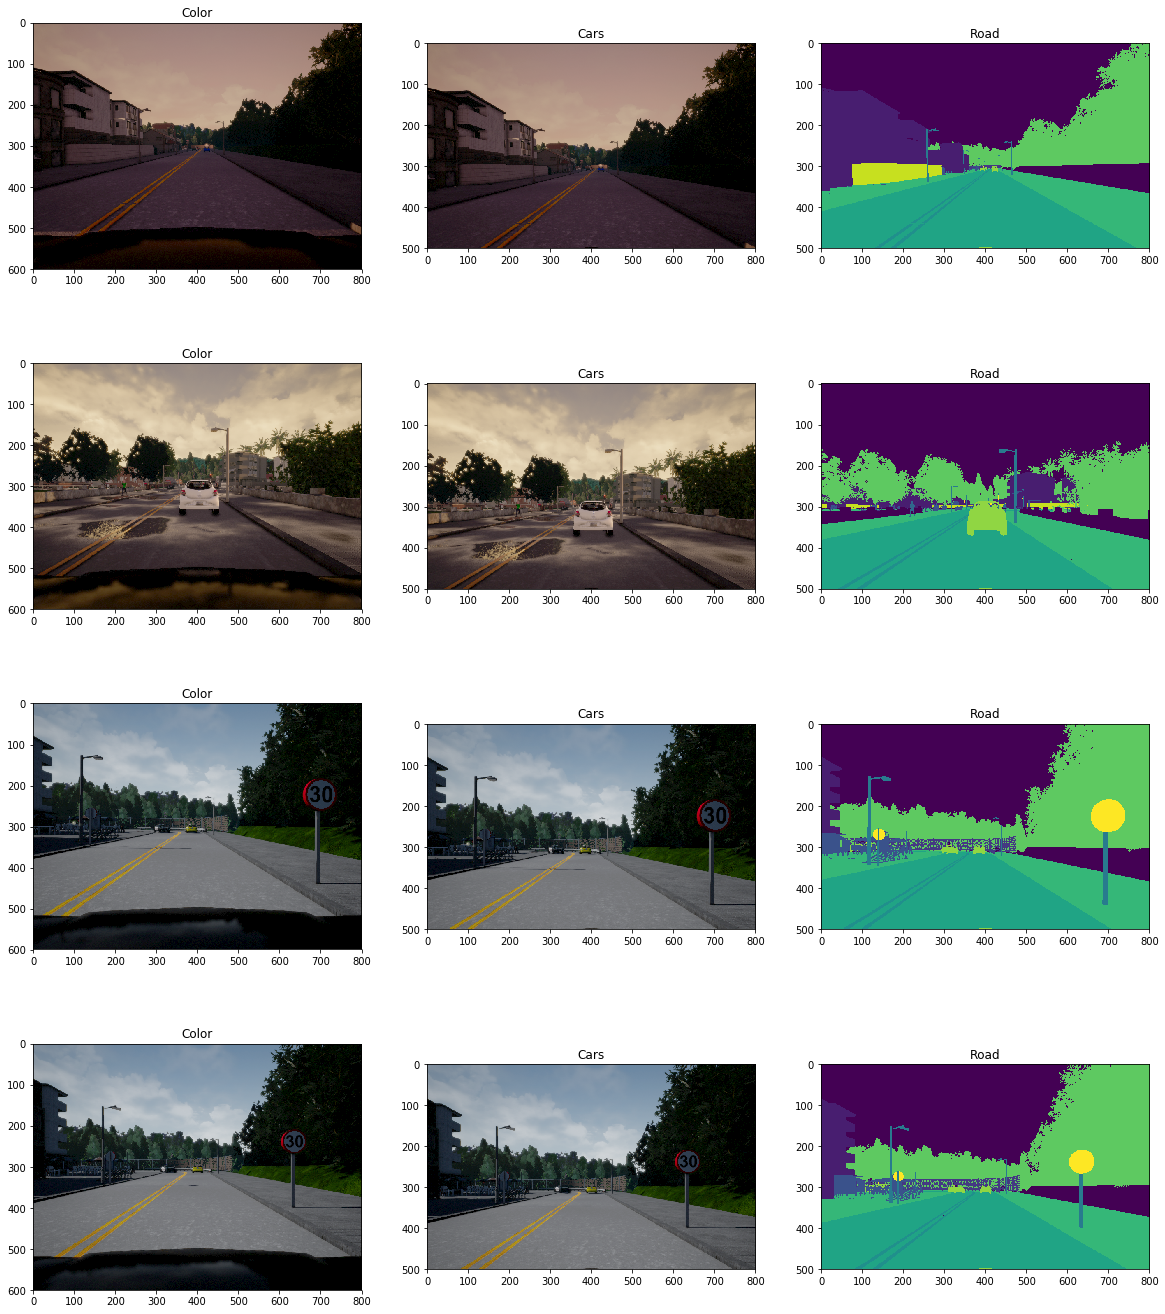

In [4]:
sample_rows = 4
fig, m_axs = plt.subplots(sample_rows, 3, figsize = (20, 6*sample_rows))
# [c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2, ax3), (_, c_row) in zip(m_axs, clara_seg_data.sample(sample_rows).iterrows()):
    c_img = imread(c_row['image'])
    
    c_img2 = c_img[:500, :, :]
    l_img = imread(c_row['label'])
    l_img = l_img[:500, :, 0]
    
    lbls = np.zeros_like(l_img)
    lbls[l_img == 10] = 1
    lbls[l_img == 7] = 2
    
    ax1.imshow(c_img)
    ax1.set_title('Color')    
    ax2.imshow(c_img2)
    ax2.set_title('Cars')
    ax3.imshow(l_img)
    ax3.set_title('Road')

In [5]:
IMG_SIZE = (480, 480) # slightly smaller than vgg16 normally expects


def process_label(lbl):
    new_lbl = np.zeros((*IMG_SIZE, 3))
    new_lbl[:, :, 0] = lbl[:, :, 0] == 7
    new_lbl[:400, :, 1] = lbl[:400, :, 0] == 10
    new_lbl[:, :, 2] = np.invert(np.logical_or(new_lbl[:, :, 0], new_lbl[:, :, 1]))
    
    return new_lbl

img_gen_args = dict(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.1, 
                              width_shift_range = 0.1, 
                              rotation_range = 3, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range = 0.05)



rgb_gen = ImageDataGenerator(preprocessing_function = preprocess_input, **img_gen_args)
lab_gen = ImageDataGenerator(preprocessing_function=process_label, **img_gen_args)

In [6]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, seed = None, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])    
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, class_mode = 'sparse',seed = seed,**dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [7]:
def train_and_lab_gen_func(in_df, batch_size = 8, seed = None):
    if seed is None:
        seed = np.random.choice(range(1000))
    
    train_rgb_gen = flow_from_dataframe(rgb_gen, 
                                        in_df, 
                                        path_col = 'image',
                                        y_col = 'id', 
                                        color_mode = 'rgb',
                                        target_size = IMG_SIZE,
                                        batch_size = batch_size,
                                        seed = seed)
    
    train_lab_gen = flow_from_dataframe(lab_gen, 
                                        in_df, 
                                        path_col = 'label',
                                        y_col = 'id', 
                                        target_size = IMG_SIZE,
                                        color_mode = 'rgb',
                                        batch_size = batch_size,
                                        seed = seed)
    
    for (x, _), (y, _) in zip(train_rgb_gen, train_lab_gen):
        yield x, y
    
train_and_lab_gen = train_and_lab_gen_func(train_df, batch_size = 32)
valid_and_lab_gen = train_and_lab_gen_func(valid_df, batch_size = 32)


In [8]:
from tensorflow.python.framework import graph_util, graph_io


In [9]:
MODEL_PATH = '../udacity-lyft-challenge/saved_models/'
FROZEN_GRAPH = '../udacity-lyft-challenge/output/fcn8.pb'

with tf.gfile.GFile(FROZEN_GRAPH, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

In [10]:
with tf.Graph().as_default() as graph:
    
    tf.import_graph_def(graph_def)

ValueError: Shape must be rank 4 but is rank 0 for 'import/block6_deconv1/conv2d_transpose' (op: 'Conv2DBackpropInput') with input shapes: ?, ?, ? and with input tensors computed as partial shapes: input[0] = [].

In [15]:
for op in graph.get_operations():
    print(op.name)

import/input_1
import/block1_conv1/kernel
import/block1_conv1/kernel/read
import/block1_conv1/bias
import/block1_conv1/bias/read
import/block1_conv1/convolution
import/block1_conv1/BiasAdd
import/block1_conv1/Relu
import/block1_conv2/kernel
import/block1_conv2/kernel/read
import/block1_conv2/bias
import/block1_conv2/bias/read
import/block1_conv2/convolution
import/block1_conv2/BiasAdd
import/block1_conv2/Relu
import/block1_pool/MaxPool
import/block2_conv1/kernel
import/block2_conv1/kernel/read
import/block2_conv1/bias
import/block2_conv1/bias/read
import/block2_conv1/convolution
import/block2_conv1/BiasAdd
import/block2_conv1/Relu
import/block2_conv2/kernel
import/block2_conv2/kernel/read
import/block2_conv2/bias
import/block2_conv2/bias/read
import/block2_conv2/convolution
import/block2_conv2/BiasAdd
import/block2_conv2/Relu
import/block2_pool/MaxPool
import/block3_conv1/kernel
import/block3_conv1/kernel/read
import/block3_conv1/bias
import/block3_conv1/bias/read
import/block3_conv1/c

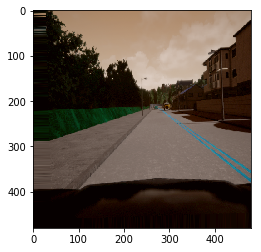

In [18]:
(rgb_batch, lab_batch) = next(valid_and_lab_gen)

rgb_img = np.clip(rgb_batch[0]+110, 0, 255).astype(np.uint8)
lab_img = lab_batch[0]

plt.imshow(rgb_img)


In [29]:
x = graph.get_tensor_by_name('import/input_1:0')
y = graph.get_tensor_by_name('import/activation_1/truediv:0')

with tf.Session(graph=graph) as sess:
    y_out = sess.run(y, feed_dict={x : np.expand_dims(rgb_img, 0)})

y_out = y_out[0]

(480, 480, 3)


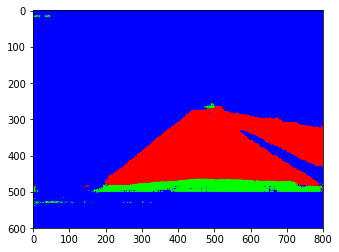

In [30]:

y_out_lbl = y_out.argmax(axis=2)

print (y_out.shape)

y_pred_color = np.zeros( (480, 480, 3))
y_pred_color[:, :, 0]  = (y_out_lbl == 0).astype(np.uint8)
y_pred_color[:, :, 1]  = y_out_lbl == 1
y_pred_color[:, :, 2]  = y_out_lbl == 2
y_pred_color = cv2.resize(y_pred_color, (800, 600))

plt.imshow(y_pred_color)